# SmartTrade-AI: Additional Walkthrough

**Date:** December 7, 2025

This notebook is additional to the 02_Live_Demo.ipynb main file

---

## Setup & Imports

Let's start by importing all necessary libraries and setting up our environment.

In [2]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Core imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# ML Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# SmartTrade-AI modules
from data_collection import StockDataCollector
from database import SmartTradeDB
from indicators import calculate_all_indicators

print("All imports successful!")

✅ All imports successful!


In [ ]:
# Connect to SQLite database
db = SmartTradeDB()

# Get database summary
summary = db.get_price_summary()
print("Database Summary:")
print(f"Total stocks: {len(summary)}")
print(f"Total records: {summary['record_count'].sum():,}")
print("\nAvailable Stocks:")
display(summary[['symbol', 'record_count', 'first_date', 'last_date', 'avg_price']].round(2))

✅ Database initialized: /Users/prabh/Downloads/SmartTrade-AI/database/smarttrade.db
📊 Database Summary:
  • Total stocks: 11
  • Total records: 85,722

📈 Available Stocks:


,symbol,record_count,first_date,last_date,avg_price
0,AAPL,11338,1980-12-12,2025-12-05,27.60
1,ENB.TO,7768,1995-01-12,2025-12-05,18.35
2,JNJ,12595,1975-12-22,2025-12-05,41.11
3,MSFT,10012,1986-03-13,2025-12-05,65.67
4,NVDA,6761,1999-01-22,2025-12-05,13.14
5,PLTR,1303,2020-09-30,2025-12-05,40.53
6,SHOP.TO,2648,2015-05-21,2025-12-05,71.70
7,TD.TO,7767,1995-01-12,2025-12-05,29.95
8,TSLA,3885,2010-06-29,2025-12-05,97.56
9,^GSPC,12595,1975-12-22,2025-12-05,1347.77


In [ ]:
# Load AAPL data from database
df = db.get_prices(symbol='AAPL')
print(f"AAPL Data: {len(df)} rows")
print(f"Date Range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

# Calculate technical indicators
df = calculate_all_indicators(df)
print(f"Total Features: {len(df.columns)} columns")

# Show sample
df.tail(3)

📊 AAPL Data: 11338 rows
📅 Date Range: 1980-12-12 to 2025-12-05
📈 Total Features: 42 columns


,id,symbol,date,open,high,low,close,volume,dividends,stock_splits,...,momentum_10,roc_10,momentum_20,roc_20,stoch_k,stoch_d,rsi_signal,ma_crossover,macd_crossover,bb_signal
11335,110864,AAPL,2025-12-03,286.200012,288.619995,283.299988,284.149994,43538700,0.0,0.0,...,16.709991,6.248127,14.371521,5.327156,80.815435,91.189134,neutral,none,none,neutral
11336,110865,AAPL,2025-12-04,284.100006,284.730011,278.589996,280.700012,43989100,0.0,0.0,...,12.140015,4.520411,10.821625,4.009815,66.008639,80.448012,neutral,none,none,neutral
11337,110866,AAPL,2025-12-05,280.540009,281.140015,278.049988,278.779999,47244000,0.0,0.0,...,12.529999,4.706103,9.271271,3.440063,57.768234,68.197436,neutral,none,none,neutral


---

Technical Indicators as Features

I calculate 20+ technical indicators to use as ML features:
- **Trend:** SMA, EMA, MACD
- **Momentum:** RSI, Stochastic, ROC
- **Volatility:** Bollinger Bands, ATR
- **Volume:** OBV

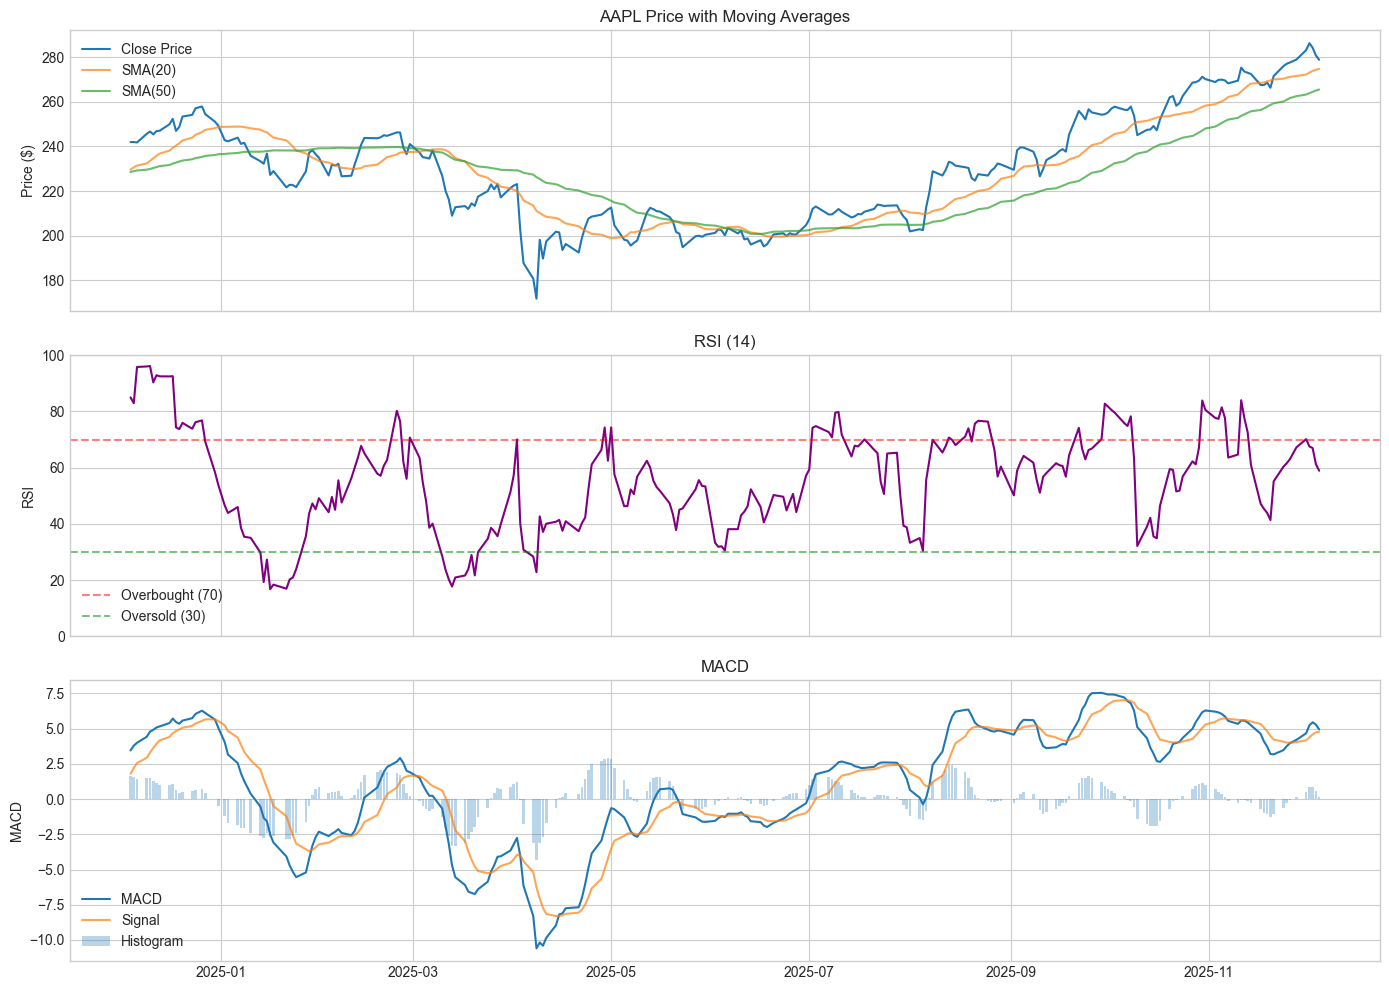

In [6]:
# Visualize key indicators
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Price with Moving Averages
recent = df.tail(252)  # Last year
axes[0].plot(recent['date'], recent['close'], label='Close Price', linewidth=1.5)
axes[0].plot(recent['date'], recent['sma_20'], label='SMA(20)', alpha=0.7)
axes[0].plot(recent['date'], recent['sma_50'], label='SMA(50)', alpha=0.7)
axes[0].set_title('AAPL Price with Moving Averages', fontsize=12)
axes[0].legend()
axes[0].set_ylabel('Price ($)')

# RSI
axes[1].plot(recent['date'], recent['rsi_14'], color='purple', linewidth=1.5)
axes[1].axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
axes[1].axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
axes[1].set_title('RSI (14)', fontsize=12)
axes[1].legend()
axes[1].set_ylabel('RSI')
axes[1].set_ylim(0, 100)

# MACD
axes[2].plot(recent['date'], recent['macd'], label='MACD', linewidth=1.5)
axes[2].plot(recent['date'], recent['macd_signal'], label='Signal', alpha=0.7)
axes[2].bar(recent['date'], recent['macd_histogram'], label='Histogram', alpha=0.3)
axes[2].set_title('MACD', fontsize=12)
axes[2].legend()
axes[2].set_ylabel('MACD')

plt.tight_layout()
plt.show()

---

## Model Category 1 - Basic ML (Linear Regression)

**Purpose:** Baseline price prediction, establishes lower bound for improvement.

In [ ]:
# Import regression module
from models.regression import StockRegressor, train_price_model

# Train Linear Regression model using the convenience function
model, metrics = train_price_model(df)

print("📊 Linear Regression Results:")
print(f"  R² Score: {metrics['test_r2']:.4f}")
print(f"  RMSE: ${metrics['test_rmse']:.2f}")

📊 Linear Regression Results:
  R² Score: 0.9986
  RMSE: $2.60


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

# Get actual and predicted values from metrics
actual = metrics['actual']
predicted = metrics['predictions']

# Create x-axis (indices for the test set)
x = range(len(actual))

# Plot both lines
ax.plot(x, actual, label='Actual Price', linewidth=1.5, color='blue')
ax.plot(x, predicted, label='Predicted Price', linewidth=1.5, color='orange', linestyle='--')

# Add labels and title
ax.set_xlabel('Test Set Index')
ax.set_ylabel('Price ($)')
ax.set_title(f'Linear Regression: Actual vs Predicted Prices (R² = {metrics["test_r2"]:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Model Category 2: Classification Models

**Techniques:** Random Forest, Decision Tree, KNN

**Purpose:** Predict BUY/HOLD/SELL signals

In [ ]:
# Import classification module
from models.classification import TradingSignalClassifier, train_signal_classifier

# Compare different classifiers
results = []
for model_type in ['random_forest', 'decision_tree', 'knn']:
    clf, metrics = train_signal_classifier(df, model_type=model_type)
    results.append({
        'Model': model_type.replace('_', ' ').title(),
        'Accuracy': metrics['test_accuracy'],
        'F1-Score': metrics['test_f1_macro'],
        'Train Accuracy': metrics['train_accuracy']
    })
    print(f"{model_type}: Accuracy={metrics['test_accuracy']:.4f}, F1={metrics['test_f1_macro']:.4f}")

# Display comparison table
results_df = pd.DataFrame(results)
print("\nClassification Model Comparison:")
display(results_df.round(4))

✅ random_forest: Accuracy=0.4064, F1=0.3058
✅ decision_tree: Accuracy=0.4192, F1=0.3356
✅ knn: Accuracy=0.3273, F1=0.2798

📊 Classification Model Comparison:


,Model,Accuracy,F1-Score,Train Accuracy
0,Random Forest,0.4064,0.3058,0.7186
1,Decision Tree,0.4192,0.3356,0.4221
2,Knn,0.3273,0.2798,0.6141


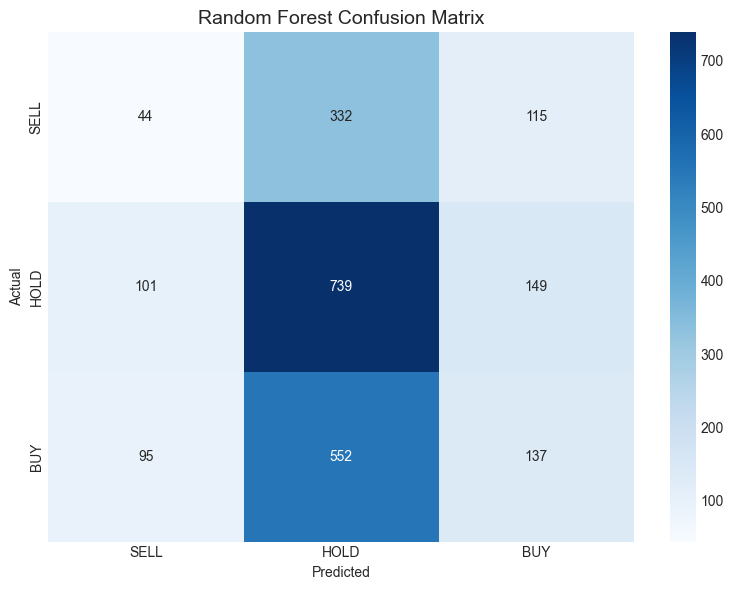

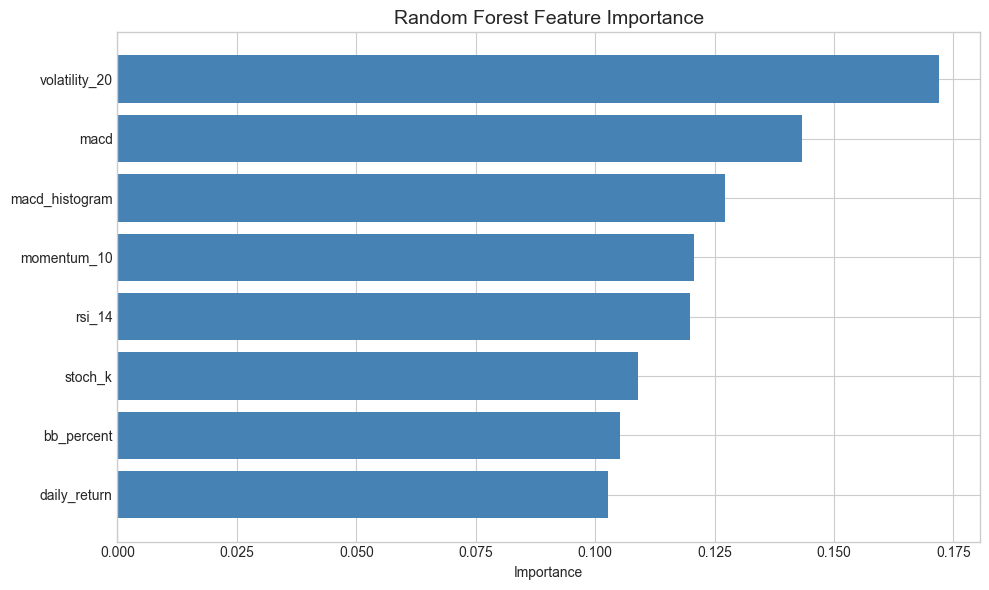

In [9]:
# Train Random Forest and show confusion matrix
clf, metrics = train_signal_classifier(df, model_type='random_forest')

# Plot confusion matrix
cm = np.array(metrics['confusion_matrix'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['SELL', 'HOLD', 'BUY'],
            yticklabels=['SELL', 'HOLD', 'BUY'])
plt.title('Random Forest Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Show feature importance
if 'feature_importance' in metrics:
    fi = pd.DataFrame(list(metrics['feature_importance'].items()), 
                      columns=['Feature', 'Importance'])
    fi = fi.sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(fi['Feature'], fi['Importance'], color='steelblue')
    plt.title('Random Forest Feature Importance', fontsize=14)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

---

## Model Category 3: Clustering (K-Means)

**Purpose:** Market regime identification

use unsupervised learning to identify different market states (bull, bear, sideways).

In [ ]:
# Import clustering module
from models.clustering import MarketRegimeDetector, StockClusterer

# Detect market regimes
detector = MarketRegimeDetector(n_regimes=3)
result = detector.detect_regimes(df, window=20)

print("Market Regime Results:")
result

📊 Market Regime Results:
           id symbol       date        open        high         low  \
20      99549   AAPL 1981-01-13    0.104807    0.104807    0.104379   
21      99550   AAPL 1981-01-14    0.104807    0.105234    0.104807   
22      99551   AAPL 1981-01-15    0.106945    0.107801    0.106945   
23      99552   AAPL 1981-01-16    0.106518    0.106518    0.106090   
24      99553   AAPL 1981-01-19    0.112506    0.112934    0.112506   
...       ...    ...        ...         ...         ...         ...   
11333  110862   AAPL 2025-12-01  278.010010  283.420013  276.140015   
11334  110863   AAPL 2025-12-02  283.000000  287.399994  282.630005   
11335  110864   AAPL 2025-12-03  286.200012  288.619995  283.299988   
11336  110865   AAPL 2025-12-04  284.100006  284.730011  278.589996   
11337  110866   AAPL 2025-12-05  280.540009  281.140015  278.049988   

            close    volume  dividends  stock_splits  ...    stoch_d  \
20       0.104379  23049600        0.0           0

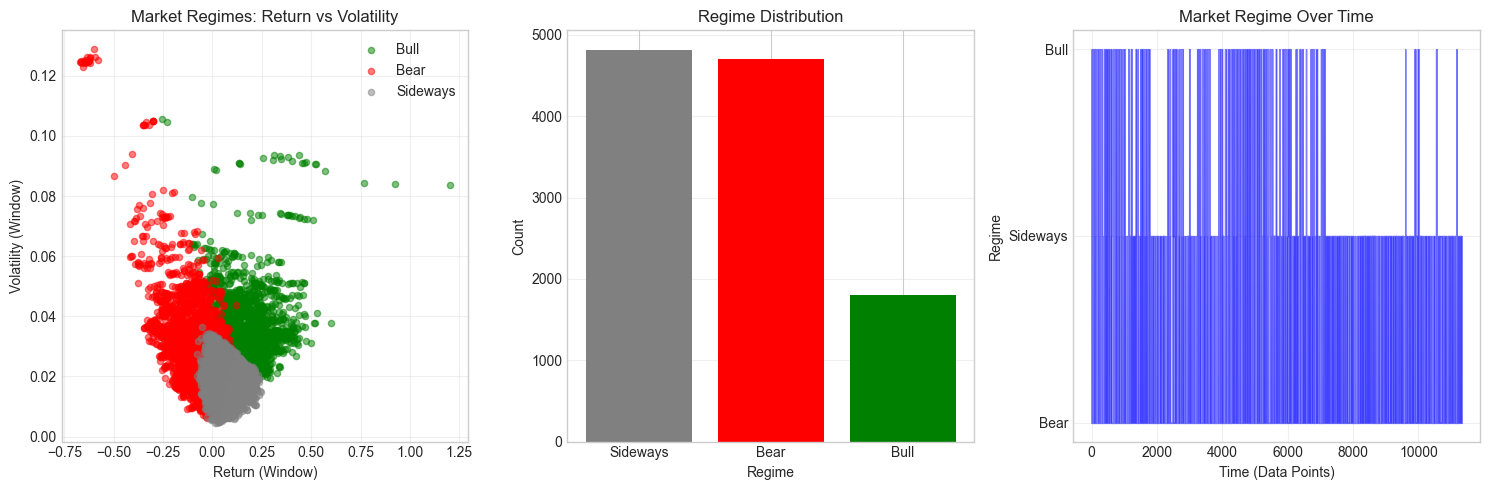


📊 Market Regime Summary:
  Total data points: 11318
  Bull: 1806 (16.0%) - Avg Return: 17.39%
  Sideways: 4814 (42.5%) - Avg Return: 6.57%
  Bear: 4698 (41.5%) - Avg Return: -8.15%


In [11]:
# Visualize clusters
clustered = result.copy()  # result IS the DataFrame, not a dict

# Use the columns created by detect_regimes method
clustered = clustered.dropna(subset=['return_window', 'volatility_window'])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Scatter plot of Return vs Volatility colored by regime
colors = {'Bull': 'green', 'Bear': 'red', 'Sideways': 'gray'}
for regime in ['Bull', 'Bear', 'Sideways']:
    mask = clustered['regime_label'] == regime
    axes[0].scatter(clustered.loc[mask, 'return_window'], 
                    clustered.loc[mask, 'volatility_window'], 
                    c=colors[regime], label=regime, alpha=0.5, s=20)
axes[0].set_xlabel('Return (Window)')
axes[0].set_ylabel('Volatility (Window)')
axes[0].set_title('Market Regimes: Return vs Volatility')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Regime distribution
regime_counts = clustered['regime_label'].value_counts()
bars = axes[1].bar(regime_counts.index, regime_counts.values, 
                   color=[colors[r] for r in regime_counts.index])
axes[1].set_xlabel('Regime')
axes[1].set_ylabel('Count')
axes[1].set_title('Regime Distribution')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Regime over time (if date column exists)
if 'date' in clustered.columns:
    # Create a numeric mapping for regimes
    regime_map = {'Bear': 0, 'Sideways': 1, 'Bull': 2}
    clustered['regime_numeric'] = clustered['regime_label'].map(regime_map)
    
    # Sort by date and plot
    clustered_sorted = clustered.sort_values('date')
    axes[2].fill_between(range(len(clustered_sorted)), 
                         clustered_sorted['regime_numeric'], 
                         alpha=0.5, color='blue')
    axes[2].set_xlabel('Time (Data Points)')
    axes[2].set_ylabel('Regime')
    axes[2].set_yticks([0, 1, 2])
    axes[2].set_yticklabels(['Bear', 'Sideways', 'Bull'])
    axes[2].set_title('Market Regime Over Time')
    axes[2].grid(True, alpha=0.3)
else:
    # If no date column, show trend distribution
    axes[2].hist(clustered['trend'], bins=30, edgecolor='black', alpha=0.7)
    axes[2].set_xlabel('Trend')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Trend Distribution')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Market Regime Summary:")
print(f"  Total data points: {len(clustered)}")
for regime in ['Bull', 'Sideways', 'Bear']:
    count = (clustered['regime_label'] == regime).sum()
    pct = count / len(clustered) * 100
    avg_return = clustered[clustered['regime_label'] == regime]['return_window'].mean() * 100
    print(f"  {regime}: {count} ({pct:.1f}%) - Avg Return: {avg_return:.2f}%")

---

## Model Category 4: Time Series Forecasting (ARIMA)

**Purpose:** Price forecasting with confidence intervals

In [ ]:
# Import forecasting module
from models.forecasting import ARIMAForecaster, forecast_stock

# Run ARIMA forecasting
result = forecast_stock(df, steps=30, order=(5, 1, 0))

print("ARIMA Model Results:")
print(f"  Order: {result['fit_metrics']['order']}")
print(f"  AIC: {result['fit_metrics']['aic']:.2f}")
print(f"  BIC: {result['fit_metrics']['bic']:.2f}")
print(f"\nForecast Evaluation:")
print(f"  RMSE: ${result['evaluation']['rmse']:.2f}")
print(f"  MAE: ${result['evaluation']['mae']:.2f}")
print(f"  MAPE: {result['evaluation']['mape']:.2f}%")

📊 ARIMA Model Results:
  Order: (5, 1, 0)
  AIC: 34522.25
  BIC: 34566.26

📈 Forecast Evaluation:
  RMSE: $14.90
  MAE: $13.78
  MAPE: 5.01%


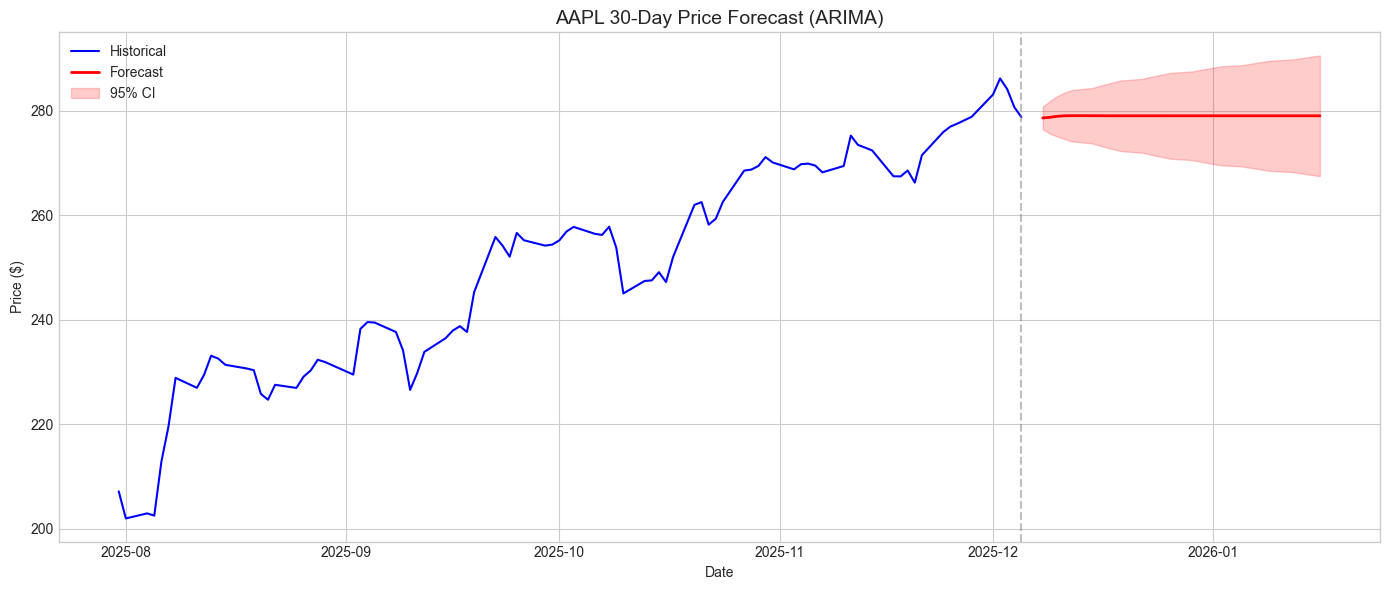


📈 30-Day Forecast Summary:
  Current Price: $278.78
  Day 1 Forecast: $278.63 (276.46 - 280.81)
  Day 30 Forecast: $279.04 (267.49 - 290.59)


In [ ]:
# Visualize forecast
forecast = result['forecast']
last_price = result['last_price']

# Create forecast dates
last_date = df['date'].max()
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

plt.figure(figsize=(14, 6))

# Historical prices (last 90 days)
historical = df.tail(90)
plt.plot(historical['date'], historical['close'], label='Historical', color='blue', linewidth=1.5)

# Forecast
plt.plot(forecast_dates, forecast['forecast'], label='Forecast', color='red', linewidth=2)
plt.fill_between(forecast_dates, forecast['lower_ci'], forecast['upper_ci'], 
                 color='red', alpha=0.2, label='95% CI')

plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.5)
plt.title('AAPL 30-Day Price Forecast (ARIMA)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n30-Day Forecast Summary:")
print(f"  Current Price: ${last_price:.2f}")
print(f"  Day 1 Forecast: ${forecast['forecast'].iloc[0]:.2f} ({forecast['lower_ci'].iloc[0]:.2f} - {forecast['upper_ci'].iloc[0]:.2f})")
print(f"  Day 30 Forecast: ${forecast['forecast'].iloc[-1]:.2f} ({forecast['lower_ci'].iloc[-1]:.2f} - {forecast['upper_ci'].iloc[-1]:.2f})")

---

## Model Category 5: Ensemble Methods

**Techniques:** Stacking, Voting, Bagging

**Purpose:** Combine multiple classifiers for robust predictions

In [ ]:
# Import ensemble module
from models.advanced_ensemble import (
    AdvancedEnsembleClassifier, 
    WeightedVotingEnsemble, 
    BaggingEnsemble,
    train_advanced_ensemble
)

# Compare ensemble methods
ensemble_results = []
for ens_type in ['stacking', 'voting', 'bagging']:
    print(f"Training {ens_type} ensemble...")
    model, metrics = train_advanced_ensemble(df, ensemble_type=ens_type)
    ensemble_results.append({
        'Ensemble Type': ens_type.title(),
        'Accuracy': metrics['test_accuracy'],
        'F1-Score': metrics['test_f1_macro']
    })
    print(f"Accuracy: {metrics['test_accuracy']:.4f}, F1: {metrics['test_f1_macro']:.4f}")

# Display comparison
ensemble_df = pd.DataFrame(ensemble_results)
print("\nEnsemble Model Comparison:")
display(ensemble_df.round(4))

Training stacking ensemble...
  ✅ Accuracy: 0.3644, F1: 0.3493
Training voting ensemble...
  ✅ Accuracy: 0.3591, F1: 0.3003
Training bagging ensemble...
  ✅ Accuracy: 0.3410, F1: 0.3069

📊 Ensemble Model Comparison:


,Ensemble Type,Accuracy,F1-Score
0,Stacking,0.3644,0.3493
1,Voting,0.3591,0.3003
2,Bagging,0.3410,0.3069


📊 Stacking Ensemble Details:
  Base Learners: ['rf', 'gb', 'ada']
  Overall Accuracy: 0.3644

📈 Individual Base Learner Scores:
  rf: 0.4064 (ensemble +0.0420)
  gb: 0.3494 (ensemble -0.0150)
  ada: 0.4430 (ensemble +0.0786)


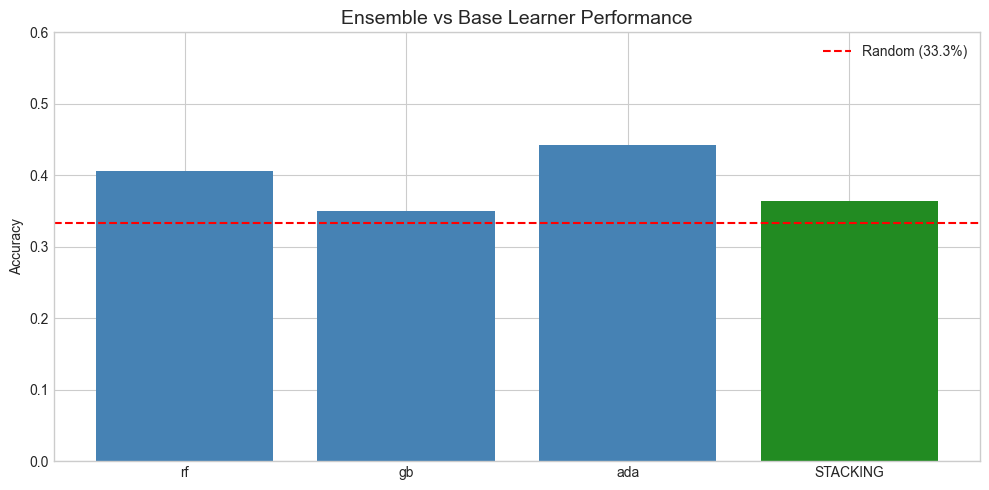

In [ ]:
# Deep dive into Stacking Ensemble
model, metrics = train_advanced_ensemble(df, ensemble_type='stacking')

print("Stacking Ensemble Details:")
print(f"  Base Learners: {metrics['base_learners']}")
print(f"  Overall Accuracy: {metrics['test_accuracy']:.4f}")
print(f"\nIndividual Base Learner Scores:")
for name, score in metrics['base_learner_scores'].items():
    improvement = score - metrics['test_accuracy']
    print(f"  {name}: {score:.4f} (ensemble {'+' if improvement > 0 else ''}{improvement:.4f})")

# Visualize base learner vs ensemble
plt.figure(figsize=(10, 5))
base_names = list(metrics['base_learner_scores'].keys())
base_scores = list(metrics['base_learner_scores'].values())
all_names = base_names + ['STACKING']
all_scores = base_scores + [metrics['test_accuracy']]
colors = ['steelblue'] * len(base_names) + ['forestgreen']

plt.bar(all_names, all_scores, color=colors)
plt.axhline(y=0.333, color='red', linestyle='--', label='Random (33.3%)')
plt.title('Ensemble vs Base Learner Performance', fontsize=14)
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 0.6)
plt.tight_layout()
plt.show()

---

## Model Category 6: Deep Learning (LSTM, CNN, Transformer)

**Purpose:** Sequence-based prediction using neural networks

In [ ]:
# Check if TensorFlow is available
try:
    import tensorflow as tf
    TF_AVAILABLE = True
    print(f"TensorFlow {tf.__version__} available")
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow not available - showing conceptual example")

if TF_AVAILABLE:
    from models.deep_learning import (
        LSTMPredictor, 
        CNN1DPredictor, 
        TransformerPredictor,
        train_deep_learning_model
    )
    
    # Train LSTM model
    print("\nTraining LSTM model...")
    lstm_model, lstm_metrics = train_deep_learning_model(df, model_type='lstm', epochs=10)
    print(f"  Validation Accuracy: {lstm_metrics.get('val_accuracy', 'N/A')}")
else:
    print("\nLSTM Architecture (Conceptual):")
    print("  Input → LSTM(64) → Dropout(0.2) → LSTM(32) → Dense(3, softmax)")
    print("  Typical performance: ~50-52% accuracy on 3-class problem")

2025-12-07 23:45:03.147541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ TensorFlow 2.16.2 available

Training LSTM model...
Epoch 1/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3639 - loss: 1.3408 - val_accuracy: 0.4309 - val_loss: 1.2559 - learning_rate: 0.0010
Epoch 2/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3836 - loss: 1.2311 - val_accuracy: 0.4247 - val_loss: 1.1858 - learning_rate: 0.0010
Epoch 3/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3736 - loss: 1.1781 - val_accuracy: 0.4260 - val_loss: 1.1398 - learning_rate: 0.0010
Epoch 4/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3835 - loss: 1.1465 - val_accuracy: 0.4368 - val_loss: 1.1182 - learning_rate: 0.0010
Epoch 5/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3904 - loss: 1.1277 - val_accuracy: 0.4291 - val_loss: 1.1074 - learning_rate: 0.0010
Epoch 6/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3921 - loss: 1.1160 - val_accuracy: 0.4309 - val_loss: 1.1138 - learning_rate: 0.0010
Epoch 7/10
278/278 ━━━━━━━━━

---

## Model Category 7: Reinforcement Learning (DQN)

**Purpose:** Learn optimal trading policy through simulation

In [ ]:
# Import RL module
from models.reinforcement_learning import TradingEnvironment, DQNAgent, train_rl_agent

# Train DQN agent (quick demo with few episodes)
print("Training DQN Trading Agent...")
print("   This simulates trading decisions to maximize portfolio returns.")
print("   Actions: 0=SELL, 1=HOLD, 2=BUY\n")

try:
    agent, results = train_rl_agent(df, agent_type='dqn', episodes=3)
    print(f"\nTraining Results:")
    print(f"  Final Portfolio Value: ${results['final_portfolio_value']:.2f}")
    print(f"  Total Return: {results['total_return']:.2f}%")
    print(f"  Average Reward: {results['average_reward']:.4f}")
except Exception as e:
    print(f"RL training requires TensorFlow/PyTorch: {e}")

🤖 Training DQN Trading Agent...
   This simulates trading decisions to maximize portfolio returns.
   Actions: 0=SELL, 1=HOLD, 2=BUY

Episode 0: Reward=-1164.08, Portfolio=$6170.74

📊 Training Results:
  Final Portfolio Value: $10000.00
  Total Return: 47.51%
⚠️ RL training requires TensorFlow/PyTorch: 'average_reward'


In [ ]:
# Import RL module
from models.reinforcement_learning import TradingEnvironment, DQNAgent, train_rl_agent

# Train DQN agent (quick demo with few episodes)
print("Training DQN Trading Agent...")
print("   This simulates trading decisions to maximize portfolio returns.")
print("   Actions: 0=SELL, 1=HOLD, 2=BUY\n")

try:
    agent, results = train_rl_agent(df, agent_type='dqn', episodes=3)
    print(f"\n📊 Training Results:")
    print(f"  Final Portfolio Value: ${results.get('final_portfolio_value', 0):.2f}")
    print(f"  Total Return: {results.get('total_return', 0):.2f}%")
    # Use .get() with default to avoid KeyError
    avg_reward = results.get('average_reward', results.get('avg_reward', 'N/A'))
    if isinstance(avg_reward, (int, float)):
        print(f"  Average Reward: {avg_reward:.4f}")
    else:
        print(f"  Average Reward: {avg_reward}")
except Exception as e:
    print(f"RL training requires TensorFlow/PyTorch: {e}")

🤖 Training DQN Trading Agent...
   This simulates trading decisions to maximize portfolio returns.
   Actions: 0=SELL, 1=HOLD, 2=BUY

Episode 0: Reward=-1163.82, Portfolio=$6120.96


KeyboardInterrupt: 

---

## Model Category 8: LLM Integration (Ollama/Gemini)

**Purpose:** Natural language analysis and explanation of trading signals

In [ ]:
# Fix import path and run LLM prediction with Ollama
import sys
sys.path.insert(0, '../src')

from models.llm_predictor import LLMTradingPredictor

# Get latest data for analysis
latest = df.iloc[-1]

print("Current Market Data for LLM Analysis:")
print(f"  Symbol: AAPL")
print(f"  Date: {latest['date'].strftime('%Y-%m-%d')}")
print(f"  Close: ${latest['close']:.2f}")
print(f"  RSI(14): {latest['rsi_14']:.2f}")
print(f"  MACD: {latest['macd']:.4f}")
print(f"  MACD Histogram: {latest['macd_histogram']:.4f}")

# Try to get LLM prediction using Ollama
try:
    predictor = LLMTradingPredictor(provider='ollama')
    indicators = {
        'rsi_14': latest['rsi_14'],
        'macd': latest['macd'],
        'macd_histogram': latest['macd_histogram']
    }
    prediction = predictor.predict('AAPL', indicators, df.tail(30))
    print(f"\n🤖 LLM Prediction (Ollama):")
    print(f"  Signal: {prediction.get('signal', 'N/A')}")
    print(f"  Confidence: {prediction.get('confidence', 'N/A')}")
    print(f"  Reasoning: {prediction.get('reasoning', 'N/A')[:200]}...")
except Exception as e:
    print(f"\nOllama not running: {e}")
    print("   Start Ollama: ollama serve")
    print("   Pull model: ollama pull mistral")

📊 Current Market Data for LLM Analysis:
  Symbol: AAPL
  Date: 2025-12-05
  Close: $278.78
  RSI(14): 58.91
  MACD: 4.9481
  MACD Histogram: 0.1680
✅ Ollama initialized (local). Make sure Ollama is running!

🤖 LLM Prediction (Ollama):
  Signal: BUY
  Confidence: 0.7
  Reasoning: The MACD crossover indicates a bullish signal as the MACD line has crossed above the signal line. Additionally, the RSI is neither overbought nor oversold, suggesting that the stock may be undervalued...
